<a href="https://colab.research.google.com/github/EfekanMutlu/Classifications_with_Pytorch/blob/main/Multi_Label_Multi_Class/Star_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Multi Label Multi Classification Example with Pytorch: Star Classification**

by *Efekan Mutlu*

In this project, I will create an example project for multi-label-multi-class using Pytorch. For this example, I will use an astronomical data set that includes stars and their characteristics, which I think is one of the most intriguing data sets among the suitable ones. Unfortunately, my data set has relatively little information compared to scientific records of this type. If I find a more recent and wider version of it (with the same data types), I will update the project. However, I believe that even with such little data, the NN model I will build will be efficient.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import metrics

In [ ]:
file="6 class csv.csv"
df=pd.read_csv(file)
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,White,A
238,9235,404940.000000,1112.0000,-11.23,5,White,A


The first 4 columns contain the variables. The column headers clearly state what they are about. The last 3 columns will be our labels. Since we only see 10 rows in the graph above, let's write the elements of these labels separately.

In [ ]:
a=df["Star type"].unique()
b=df["Star color"].unique()
c=df["Spectral Class"].unique()
print("star type:",a,"length",len(a))
print("star color:",b,"length",len(b))
print("spectral class:",c,"length",len(c))

star type: [0 1 2 3 4 5] length 6
star color: ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White'] length 19
spectral class: ['M' 'B' 'A' 'F' 'O' 'K' 'G'] length 7


The star names are clearly visible, but the star types are represented by numbers; while the spectral class is represented by letters. These mean:


*   For **Star Type:**
  1. Brown Dwarf -> Star Type = **0**

  2. Red Dwarf -> Star Type = **1**

  3. White Dwarf-> Star Type = **2**

  4. Main Sequence -> Star Type = **3**

  5. Supergiant -> Star Type = **4**

  6. Hypergiant -> Star Type = **5**


*   For **Specral Class:**

  1. **O:**	Surface Temperature:>25,000K	
  2. **B:**	Surface Temperature:10,000-25,000K	
  3. **A:**	Surface Temperature:7,500-10,000K	
  4. **F:**	Surface Temperature:6,000-7,500K	
  5. **G:**	Surface Temperature:5,000-6,000K	
  6. **K:**	Surface Temperature:3,500-5,000K	
  7. **M:**	Surface Temperature:< 3,500K	



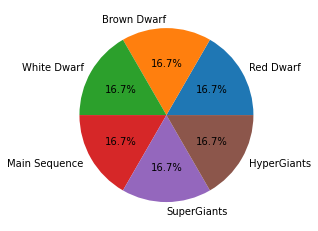

In [ ]:
plt.pie(df['Star type'].value_counts(),autopct="%1.1f%%",labels=["Red Dwarf", "Brown Dwarf", "White Dwarf", "Main Sequence" , "SuperGiants", "HyperGiants"])
plt.show()

As seen, our star types are evenly distributed in the dataset. Before building our model, in order to see what we are dealing with, we need to compare the 4 variables against the 3 labels and examine the data distribution. Unfortunately, since there are more than 3 variables, we cannot prepare a 2D or 3D plot. Therefore, a 4x4 matrix will be useful for us. We need to create separate matrices for each label. It would be more logical to run them in separate cells instead of subplot form for easier examination.

In [ ]:
fig1=px.scatter_matrix(data_frame=df,dimensions=["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)"], 
                                 color="Star type",width=1200, height=800)
fig1.show()

In [ ]:
fig2=px.scatter_matrix(data_frame=df,dimensions=["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)"], 
                                 color="Star color",width=1200, height=800)
fig2.show()

In [ ]:
fig3=px.scatter_matrix(data_frame=df,dimensions=["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)"], 
                                 color="Spectral Class",width=1200, height=800)
fig3.show()

As seen in the above 3 matrices, our data has not taken the form of a circle and has mostly arranged in the form of slight curves. In this case, a linear layers and an activation code of relu in a NN architecture can handle our task quite well.

Now that we've analyzed our data and the distributions of our labels, we can start building our model. First, we have to preprocess the data. Normally, we would group each of our labels' classes with the one-hot encoding method. But in this case, it would add unnecessary load to our model. Instead, we can code our labels in numerical form. This way, not only will our computer work faster (it's not that important for our current 240 rows, but let's take precautions for a potentially updated dataset in the future), but it also prevents potential issues with tensor dimensions that we might encounter later on.

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Star color"] = label_encoder.fit_transform(df["Star color"])
df["Spectral Class"] = label_encoder.fit_transform(df["Spectral Class"])
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,10,5
1,3042,0.000500,0.1542,16.60,0,10,5
2,2600,0.000300,0.1020,18.70,0,10,5
3,2800,0.000200,0.1600,16.65,0,10,5
4,1939,0.000138,0.1030,20.06,0,10,5
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,0,6
236,30839,834042.000000,1194.0000,-10.63,5,0,6
237,8829,537493.000000,1423.0000,-10.73,5,11,0
238,9235,404940.000000,1112.0000,-11.23,5,11,0


In [ ]:
y=df.iloc[:,-3:]
y=np.array(y)#Preparing targets for the model and convert to numpy array to avoid various long and float errors in the future. Also it's faster

In [ ]:
x = df.iloc[:, 0:-3]
x=np.array(x)

In [ ]:
# First, our data is divided into train+val - test
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, random_state=69)

# "then, the train and validation data are also divided among themselves
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

In [ ]:
#preparing the divided data for scaling.,
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
#preparing mini batches
class MultiDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        features = self.x[index, :]
        labels = self.y[index, :]
        
        features = torch.tensor(features, dtype=torch.float32)
        label1 = torch.tensor(labels[0], dtype=torch.long)
        label2 = torch.tensor(labels[1], dtype=torch.long)
        label3 = torch.tensor(labels[2], dtype=torch.long)
        return {
            'features': features,
            'label1': label1,
            'label2': label2,
            'label3': label3,  }

# dataset
train_dataset = MultiDataset(X_train, y_train)
val_dataset= MultiDataset(X_train, y_train)
test_dataset = MultiDataset(X_val, y_val)
#data loader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=16)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

In [ ]:
class MultiLabelMultiCategory(nn.Module):
    def __init__(self):
        super(MultiLabelMultiCategory, self).__init__()
        self.layer_1 = nn.Linear(4, 512)#We are inputting four variables into the neural network
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.out1 = nn.Linear(64, 6)
        self.out2 = nn.Linear(64, 19)#We are adjusting the output dim according to the class of the labels. 
        self.out3 = nn.Linear(64, 7) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        #I used dropout and batch normalization to reduce overfitting

    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        out1 = F.softmax(self.out1(x))
        out2 = F.softmax(self.out2(x))
        out3 = F.softmax(self.out3(x))
        #Even though there is only one input, we are making separate outputs for each label.

        return out1, out2, out3

In [ ]:
#We need to update the loss function for 3 labels.
def multi_category_loss_fn(outputs, targets):
    o1, o2, o3 = outputs
    t1, t2, t3 = targets
    l1 = nn.CrossEntropyLoss()(o1, t1)#As we are working on multi-class, we will use cross-entropy loss
    l2 = nn.CrossEntropyLoss()(o2, t2)
    l3 = nn.CrossEntropyLoss()(o3, t3)
    return (l1 + l2 + l3 ) / 3 

In [ ]:
#To measure the efficiency of our model during training and testing, I will define a function beforehand.
def multi_acc(outputs, targets):
    correct = 0
    for i in range(len(outputs)):
        pred = outputs[i].argmax(dim=1)
        correct += (pred == targets[i]).sum().item()
    acc = (correct / len(outputs)) * 100
    return acc

In [ ]:
# training function
def train(model,EPOCHS,optimizer,train_loader,val_loader,criterion,device,multi_acc):
      accuracy_stats = {'train': [],"val": []}
      loss_stats = {'train': [],"val": []}##I will use a dictionary to monitor loss and accurancy changes more easily.
      for e in tqdm(range(EPOCHS)):
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for i, data in enumerate(train_loader):

          features = data['features'].to(device)
          t_target1 = data['label1'].to(device)
          t_target2 = data['label2'].to(device)
          t_target3 = data['label3'].to(device)
        
          optimizer.zero_grad()
        
          train_outputs = model(features)
          train_targets = (t_target1, t_target2, t_target3)
          tr_loss = criterion(train_outputs, train_targets)
          train_acc = multi_acc(train_outputs, train_targets)
          
#The training process is a standard PyTorch training code. 
#The only difference is that we calculate the loss separately for 3 labels and perform backpropagation accordingly.
        
          tr_loss.backward()
          optimizer.step()
          train_epoch_loss += tr_loss.item()
          train_epoch_acc += train_acc

        with torch.no_grad():
          val_epoch_loss = 0
          val_epoch_acc = 0
          model.eval()
          for i, data in enumerate(val_loader):
            
            features = data['features'].to(device)
            v_target1 = data['label1'].to(device)
            v_target2 = data['label2'].to(device)
            v_target3 = data['label3'].to(device)

            val_outputs = model(features)
            val_targets = (v_target1, v_target2, v_target3)
            val_loss = criterion(val_outputs, val_targets)
            val_acc = multi_acc(val_outputs, val_targets)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
      return accuracy_stats, loss_stats


In [ ]:
model = MultiLabelMultiCategory()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
model.to(device)
# start the training
print("Begin training.")
accuracy_stats,loss_stats=train(model,epochs,optimizer,train_dataloader,val_dataloader,multi_category_loss_fn,device,multi_acc)

Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-45-18097e228d3d>:32: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

<ipython-input-45-18097e228d3d>:33: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

<ipython-input-45-18097e228d3d>:34: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Text(0.5, 1.0, 'Train-Val Loss/Epoch')

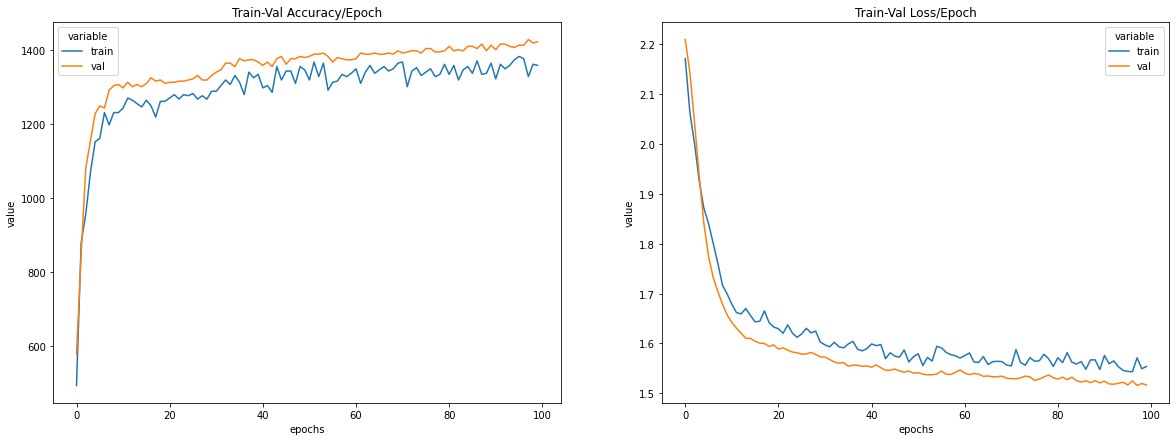

In [ ]:
# Plotting accuracy and loss for train and validation per epoch
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:

# an empty list to store the predicted labels
predicted_labels = []
# an empty list to store the true labels
true_labels = []

# Iterate over the test dataloader
for i, test_sample in enumerate(test_dataloader):
    # extract the features and labels
    test_features = test_sample['features'].to(device)
    test_target1 = test_sample['label1'].to(device)
    test_target2 = test_sample['label2'].to(device)
    test_target3 = test_sample['label3'].to(device)
    
    test_outputs = model(test_features)
            
    # get all the output labels
    for out in test_outputs:
        predicted_labels.append(int(np.argmax(out.detach().cpu())))
        
    targets = (test_target1, test_target2, test_target3)
    # get all the targets in int format from tensor format
    for target in targets:
        true_labels.append(int(target.squeeze(0).detach().cpu()))

<ipython-input-45-18097e228d3d>:32: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

<ipython-input-45-18097e228d3d>:33: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

<ipython-input-45-18097e228d3d>:34: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



In [ ]:
#Printing accuracy score
print(accuracy_score(true_labels, predicted_labels))

0.9


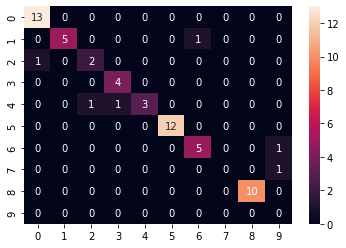

In [ ]:
# Creating confusion matrix
sns.heatmap(confusion_matrix(true_labels, predicted_labels), annot=True, fmt='d')

In [ ]:
#Classification report from matrix
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.83      0.91         6
           2       0.67      0.67      0.67         3
           3       0.80      1.00      0.89         4
           4       1.00      0.60      0.75         5
           5       1.00      1.00      1.00        12
           6       0.83      0.83      0.83         6
           8       0.00      0.00      0.00         1
          10       1.00      1.00      1.00        10
          17       0.00      0.00      0.00         0

    accuracy                           0.90        60
   macro avg       0.72      0.69      0.70        60
weighted avg       0.92      0.90      0.90        60



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control 

Despite having limited data, our model has performed quite efficiently and made continuous accurate predictions. This can be seen in both the train-val accuracy & loss graphs and the accuracy score. When we look at the confusion matrix, all densities are distributed diagonally. There were 54 correct predictions and only 6 errors. By looking at the high recall and precision values in the classification report, we can confirm this situation.

*Thanks for your time*